In [1]:
from __future__ import division

from IPython.display import display

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from scipy import stats
import os
from os import path
import time
import seaborn as sns

from biom import load_table
from biom.table import Table
from biom.exception import UnknownIDError

%matplotlib inline

In [2]:
# read in metadata
meta = pd.read_table("../data/797_prep_296_qiime_20150818-225202.txt", index_col=0)
meta = meta.sort_index()

# get rid of dogs
meta = meta[meta.host_common_name=="human"]

# read in biom table
table = load_table("../data/153_otu_table.biom")

# get rid of samples with < 1000 reads
table.filter(table.ids()[table.sum(axis="sample") > 1000])

# match samples in both table and metadata
in_both = set(table.ids()) & set(meta.index)
table.filter(in_both)
meta = meta.loc[list(in_both)]

# get only samples which have all 5 samples (2 palms, forehead, tongue, stool)
all_samples_names = [i for i in set(meta.anonymized_name) if meta.loc[meta.anonymized_name==i].shape[0] == 5]
all_samples_samples = [i for i in meta.index if meta.loc[i, "anonymized_name"] in all_samples_names]
table.filter(all_samples_samples)
meta = meta.loc[all_samples_samples]

print table.shape
print meta.shape

(15974, 700)
(700, 64)


In [3]:
def read_in_results(fp):
    # read in results files
    # read in all sink predictions and make mega dataframe
    sink_predictions = []
    folders = glob(path.join(fp, '*'))
    if len(folders) == 0:
        raise ValueError("No folders present to read in")
    for folder in folders:
        try:
            sink_pred = pd.read_table(folder+'/sink_predictions.txt', index_col=0)
        except IOError:
            print folder
            continue
        sink_predictions.append(sink_pred)

    sink_predictions = pd.concat(sink_predictions)
    sink_predictions = sink_predictions.sort_index()

    sink_predictions['proportion'] = [float(i.split('_')[-2]) if len(i.split('_')) > 1 else 0 for i in sink_predictions.index]
    sink_predictions['individual'] = [i.split('_')[0] for i in sink_predictions.index]
    return sink_predictions

def summarize_sites(df):
    sites = [i.split('_')[0].split('.')[-1] if len(i.split('_')[0].split('.')) > 1 else i for i in df.columns]
    return df.groupby(sites, axis=1).sum()

def plot_individuals(df, body_site):
    individuals = list(set(df.individual))
    cm = plt.get_cmap('PiYG')
    colors = [cm(1.*i/len(individuals)) for i in xrange(len(individuals))]
    for i, individual in enumerate(individuals):
        subset = df[df.individual == individual]
        plt.scatter(subset.proportion, subset[body_site], color=colors[i], label=individual)
#         plt.scatter(subset.proportion, subset[body_site], label=individual)
    plt.xlim((0,1))
    plt.ylim((0,1))
#     plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.subplots_adjust(right=0.8)

def plot_individuals_ungrouped(df, body_site):
    individuals = list(set(df.individual))
    cm = plt.get_cmap()
    colors = [cm(1.*i/len(individuals)) for i in xrange(len(individuals))]
    for i, individual in enumerate(individuals):
        subset = df[df.individual == individual]
        individual_body_site = '.'.join(individual.split('.')[:-1] + [body_site])
        plt.scatter(subset.proportion, subset[individual_body_site], color=colors[i], label=individual)
    plt.xlim((0,1))
    plt.ylim((0,1))
#     plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.subplots_adjust(right=0.8)

def determine_min_sig(spikein_results, body_site):
    individuals = list(set(spikein_results.individual))
    slopes = list()
    for individual in individuals:
        subset = spikein_results[spikein_results.individual == individual]
        regress = stats.linregress(subset.proportion, subset[body_site])
        slopes.append(regress.slope)
    return np.mean(slopes)

def determine_min_sig_ungrouped(spikein_results, body_site):
    individuals = list(set(spikein_results.individual))
    slopes = list()
    for individual in individuals:
        subset = spikein_results[spikein_results.individual == individual]
        individual_body_site = '.'.join(individual.split('.')[:-1] + [body_site])
        regress = stats.linregress(subset.proportion, subset[individual_body_site])
        slopes.append(regress.slope)
    return np.mean(slopes)

# Stool analysis

## Stool amount

In [6]:
stool_spike_predictions = read_in_results("min_percent/spiked_results_stool_20170303152455/")
stool_spike_site_predictions = summarize_sites(stool_spike_predictions)

0.97516944444444431

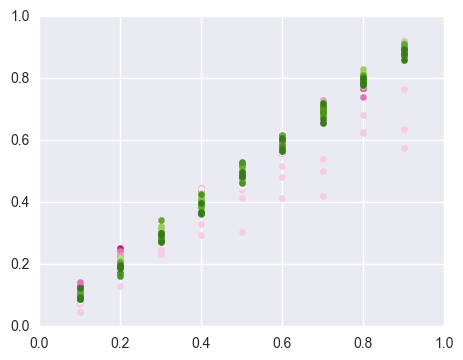

In [7]:
plot_individuals(stool_spike_site_predictions, "Stool")
determine_min_sig(stool_spike_site_predictions, "Stool")

## Individual Stool amount

0.86474249999999986

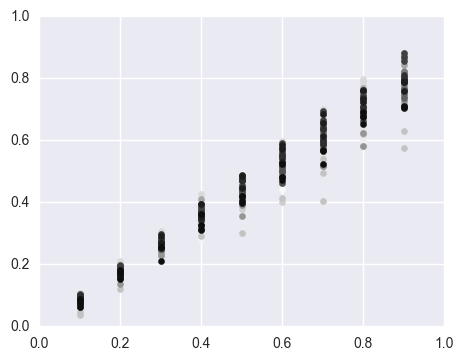

In [8]:
plot_individuals_ungrouped(stool_spike_predictions, "Stool")
determine_min_sig_ungrouped(stool_spike_predictions, "Stool")

# Out Stool analysis

In [9]:
outstool_spike_predictions = read_in_results("min_percent/spiked_results_stool_20170303153652/")
outstool_spike_site_predictions = summarize_sites(outstool_spike_predictions)

0.9579924999999998

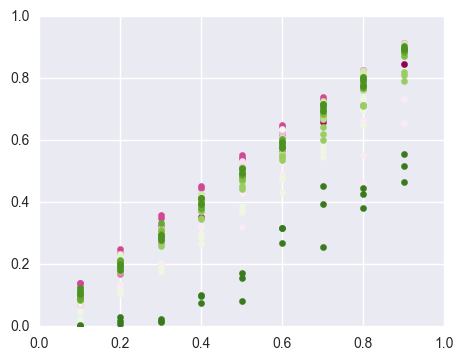

In [10]:
plot_individuals(outstool_spike_site_predictions, 'Stool')
determine_min_sig(outstool_spike_site_predictions, 'Stool')

# Merged out and in stool

0.96853666666666649

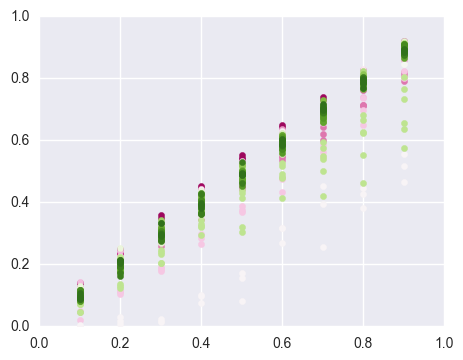

In [11]:
merged = pd.concat([stool_spike_site_predictions, outstool_spike_site_predictions])
merged = merged.sort_index()
plot_individuals(merged, 'Stool')
determine_min_sig(merged, 'Stool')

# Tongue Analysis

In [12]:
tongue_spike_predictions = read_in_results("min_percent/spiked_results_tongue_20170305082237/")
tongue_spike_site_predictions = summarize_sites(tongue_spike_predictions)

## Tongue Analysis

0.97017527777777757

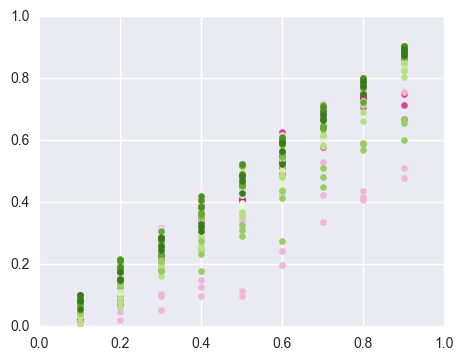

In [13]:
plot_individuals(tongue_spike_site_predictions, 'Tongue')
determine_min_sig(tongue_spike_site_predictions, 'Tongue')

## Individual Tongue Analysis

0.81883694444444433

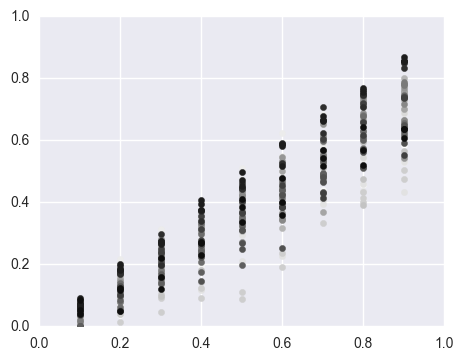

In [14]:
plot_individuals_ungrouped(tongue_spike_predictions, 'Tongue')
determine_min_sig_ungrouped(tongue_spike_predictions, 'Tongue')